In [2]:
#whole lotta inputs ASTRO RELated
#from astroquery.vizier import Vizier
#import astropy.units as u
#import pandas as pd

import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
#import astropy.coordinates as coord
#import astropy.units as u
#import csv
#import astropy.io.ascii as ascii
#from astropy.table import Table, join, unique
import pandas as pd
import numpy as np



#import os
#import time
#import sys
#import shutil
#from datetime import datetime
#import math
#import matplotlib.cm as cm
#import matplotlib.patheffects as PathEffects
#import matplotlib.colors as pltcolors
#from matplotlib import gridspec
#import matplotlib.ticker as ticker
#import matplotlib.colors as csx
#import colorsys
#import colormaps as cmaps
#from scipy.stats import norm

#from astropy.stats import mad_std
#from astropy.io import fits
#from astropy.timeseries import LombScargle
#from astropy.coordinates import ICRS, SkyCoord, Galactic, Galactocentric, GalacticLSR, LSR, CartesianRepresentation
#import astropy.units as u
#import astropy.constants as c
#from astropy.table import Table

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
#import astropy
#from astropy.visualization.wcsaxes import WCSAxes

#from collections import Counter
import warnings

#machine learning inputs

# Load in Data and make data cuts
- T-eff < 7000 to exclude high mass stars and most white dwarfs. 
- parallax > 1e-5
- G band Magnitude <18


In [112]:
colnames = [
    "starID",  #Assigned star ID
    "Gaia", #Star ID from Gaia catalog
    "Teff", #Effective temperature of the star (a derived quantity)
    "e_Teff", #Error in effective temperature
    "logg", #Log surface gravity
    "e_logg", #error in surface gravity
    "FeH", #Metallicity (ratio of iron to hydrogen)
    "e_FeH", #error in metallicity
    "Dist", #Distance to star
    "e_Dist", #Error in distance to star
    "Av", #Extintion of light along the line of sight 
    "e_Av", #error in extinction
    "Fbol", #Bolometric flux (integrated over all wavelengths)
    "e_Fbol", #Error in bolometric flux
    "angRad", #angular radius of star
    "e_angRad", #Error in angular radius
    "logL", #log bolometric luminosity
    "e_logL", #error in log luminosity
    "radius", #radius of the star
    "e_radius", #error in radius
    "npoint", #number of points in flux
    "source", #target source
    "ruwe", #Gaia weighted error
    "RAdeg", #RA coordinate in degrees
    "DEdeg", #DEC coordinate in degrees
    "GLON", #galactic latitude
    "GLAT", #galactic latitude
    "Uniq", #is it a unique point
    "BinarySource" #yes or no is it a binary source
]

# Read in the file — adjust `skiprows` to match your file (e.g., skip header block)
chunks = pd.read_csv("apjsacabc8t4_mrt.txt", names=colnames, sep=r"\s+", comment='#', engine='python', chunksize=50000)

In [113]:
filtered_chunks=[]
for chunk in chunks:
    chunk = chunk[pd.to_numeric(chunk['Teff'], errors='coerce') < 9000]
    chunk = chunk[chunk['Uniq'] == 'Y']
    chunk = chunk.drop(['starID', 'Gaia', 'BinarySource', 'Uniq', 'ruwe', 'source'], axis=1)
    chunk = chunk.apply(pd.to_numeric, errors='coerce')
    chunk = chunk.dropna()
    filtered_chunks.append(chunk)

df = pd.concat(filtered_chunks)

In [114]:
df.head()

,Teff,e_Teff,logg,e_logg,FeH,e_FeH,Dist,e_Dist,Av,e_Av,...,e_angRad,logL,e_logL,radius,e_radius,npoint,RAdeg,DEdeg,GLON,GLAT
59,4226.1,141.9,4.62,0.07,-0.13,0.12,142.844,0.187,0.143,0.198,...,0.00158,-0.976,0.037,0.608,0.049,16.0,53.221178,-68.674790,284.403250,-42.173533
61,4908.7,171.8,2.32,0.08,-1.18,0.19,3483.971,100.874,0.112,0.160,...,0.00107,1.667,0.048,9.451,0.846,19.0,55.593978,-68.697933,283.721464,-41.476288
62,5560.0,153.3,4.07,0.06,0.02,0.10,800.286,10.866,0.149,0.118,...,0.00068,0.401,0.037,1.716,0.120,19.0,54.392074,-68.685000,284.059066,-41.833071
63,5623.7,156.4,4.28,0.06,-0.03,0.11,411.509,4.184,0.057,0.117,...,0.00103,0.190,0.037,1.315,0.092,19.0,55.770496,-68.722452,283.697372,-41.410086
64,6024.5,164.4,4.19,0.06,-0.35,0.15,549.269,10.376,0.078,0.107,...,0.00083,0.377,0.040,1.421,0.102,19.0,55.738304,-68.746178,283.732101,-41.405527


In [115]:
df.to_csv('GALAH_APOGEE_RAVE.csv', index=False)

In [21]:
from astropy.constants import iau2015

def get_Mbol(logLbol):
    Mbol = 71.19-(2.5*logLbol) #IAU 2015 definition
    return Mbol

Mbol_Yu = get_Mbol(df['logL'])

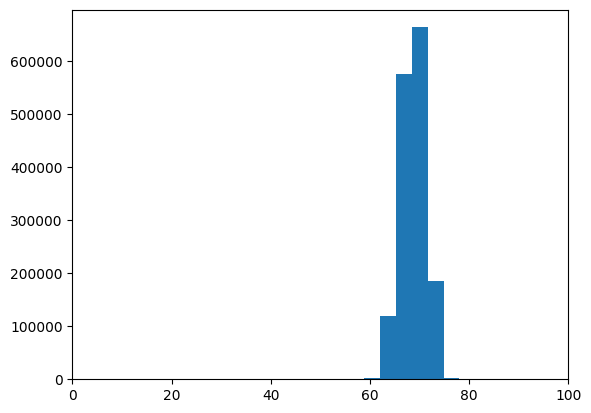

In [28]:
plt.hist(Mbol_Yu,bins=150)
plt.xlim(0,100)
plt.show()

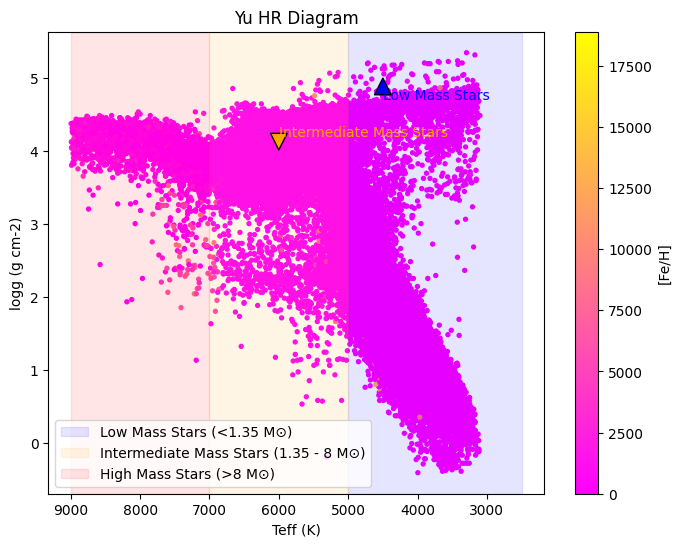

In [35]:
plt.figure(figsize=(8, 6))

sc = plt.scatter(df['Teff'].iloc[::5], df['logg'].iloc[::5], c=df['FeH'].iloc[::5], cmap='spring', s=8)
plt.colorbar(sc, label='[Fe/H]')
plt.gca().invert_xaxis()
plt.xlabel('Teff (K)')
plt.ylabel("logg (g cm-2)")
plt.title("Yu HR Diagram")

#Hr diagram markers 
teff = df['Teff']
# Define mass boundaries (for example, in solar masses)
low_mass = (teff < 6450)  # Low mass stars have lower Teff (this is a rough example)
intermediate_mass = (teff >= 6550) & (teff < 7000)  # Intermediate mass
high_mass = (teff >= 7000)  # High mass stars

# Plot shaded regions for mass groups
plt.axvspan(2500, 5000, color='blue', alpha=0.1, label='Low Mass Stars (<1.35 M⊙)')
plt.axvspan(5000, 7000, color='orange', alpha=0.1, label='Intermediate Mass Stars (1.35 - 8 M⊙)')
plt.axvspan(7000, 9000, color='red', alpha=0.1, label='High Mass Stars (>8 M⊙)')

# Annotating the regions (optional)
plt.annotate('Low Mass Stars', xy=(4500, 5), xytext=(4500, 4.7),
             arrowprops=dict(facecolor='blue', shrink=0.05), color='blue', fontsize=10)
plt.annotate('Intermediate Mass Stars', xy=(6000, 4), xytext=(6000, 4.2),
             arrowprops=dict(facecolor='orange', shrink=0.05), color='orange', fontsize=10)
plt.annotate('High Mass Stars', xy=(18000, -2), xytext=(18000, -2.2),
             arrowprops=dict(facecolor='red', shrink=0.05), color='red', fontsize=10)

# Show the plot
plt.legend()
plt.show()

In [125]:
fitcols = [
    "Teff", #Effective temperature of the star (a derived quantity)
    #"e_Teff", #Error in effective temperature
    "logg", #Log surface gravity
    #"e_logg", #error in surface gravity
    "FeH", #Metallicity (ratio of iron to hydrogen)
    #"e_FeH", #error in metallicity
    "Fbol", #Bolometric flux (integrated over all wavelengths)
    #"e_Fbol", #Error in bolometric flux
    "angRad", #angular radius of star
    #"e_angRad", #Error in angular radius
    "logL", #log bolometric luminosity
    #"e_logL", #error in log luminosity
    "radius", #radius of the star
    #"e_radius", #error in radius
]
X = df[fitcols]

In [126]:
#Cluster data
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)

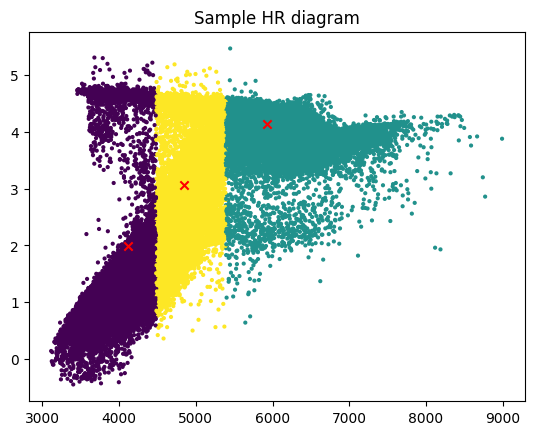

In [128]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_
plt.scatter(X['Teff'].iloc[::5], X['logg'].iloc[::5], c=labels[::5], s=4)
plt.scatter(np.array(centers[:,0]), np.array(centers[:,1]), marker='x', c='r')
plt.title("Sample HR diagram")
plt.show()

It's interesting that despite not telling the algorithm anything about physics, it winds up with these vertical divisions based on temperature anyway. What happens when we take away Teff information?

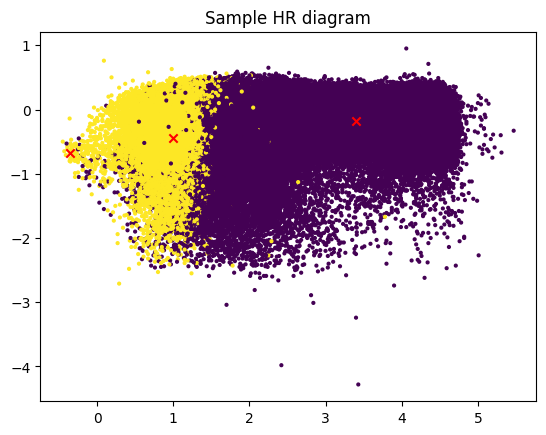

In [129]:
fitcols = [
    #"Teff", #Effective temperature of the star (a derived quantity)
    #"e_Teff", #Error in effective temperature
    "logg", #Log surface gravity
    #"e_logg", #error in surface gravity
    "FeH", #Metallicity (ratio of iron to hydrogen)
    #"e_FeH", #error in metallicity
    "Fbol", #Bolometric flux (integrated over all wavelengths)
    #"e_Fbol", #Error in bolometric flux
    "angRad", #angular radius of star
    #"e_angRad", #Error in angular radius
    "logL", #log bolometric luminosity
    #"e_logL", #error in log luminosity
    "radius", #radius of the star
    #"e_radius", #error in radius
]
X = df[fitcols]
y=df['Teff']
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
plt.scatter(X['logg'].iloc[::5], X['FeH'].iloc[::5], c=labels[::5], s=4)
plt.scatter(np.array(centers[:,0]), np.array(centers[:,1]), marker='x', c='r')
plt.title("Sample HR diagram")
plt.show()

label the original categories and see if these end up being the same (quantify how many are different than the original categorization)

In [73]:
centers[:,0], centers[:,2]

(array([3.97417608, 2.3716875 , 3.25075221]),
 array([0.01712065, 0.00791569, 0.0002492 ]))